![Py4Eng](img/logo.png)

# Softmax Model
## Yoav Ram

In this session we will understand:
- how to use multinomial logistic regression to classify samples to multiple categories
- why sometimes linear models like logistic regression are not enough
- first steps in working with images
- first steps with generator functions
- polynoimal fitting and polynomial features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax
import jax.numpy as np
import pandas as pd
from scipy.special import logit, expit
import seaborn as sns
from sklearn.metrics import confusion_matrix

# import warnings
# warnings.simplefilter('ignore', FutureWarning)
# warnings.simplefilter('ignore', UserWarning)

blue, green, red = sns.color_palette('muted', 3)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

# Image classification: MNIST dataset

We continue with classification, this time we want to classify an image. 

We'll use a classical image classification problem, the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset of  handwritten digits. 
Since we will use Keras later anyway, we can get the images from the `keras.datasets` module which is distributed with Keras, which, in turn, is distributed with TensorFlow since version 1.4, which is distributed with Anaconda.

First we read the data sets:

In [2]:
from tensorflow import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()


Now we pull the images, which are our *features* for this problem, the independent variables.
The images are already divided to training and test images, and they are 28x28 pixels each (for a total of 784 features per sample!).

So `X_train` and `X_test` are arrays of shape (nsamples, 28, 28).

In [3]:
nsamples, width, height = X_train.shape
nfeatures = width * height

print(X_test[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 19

Images are just matrices, as you can see.
Matplotlib has two functions to plot matrices - `matshow` and `imshow`, where the main difference is that `imshow` is designed for images and does interpolation.

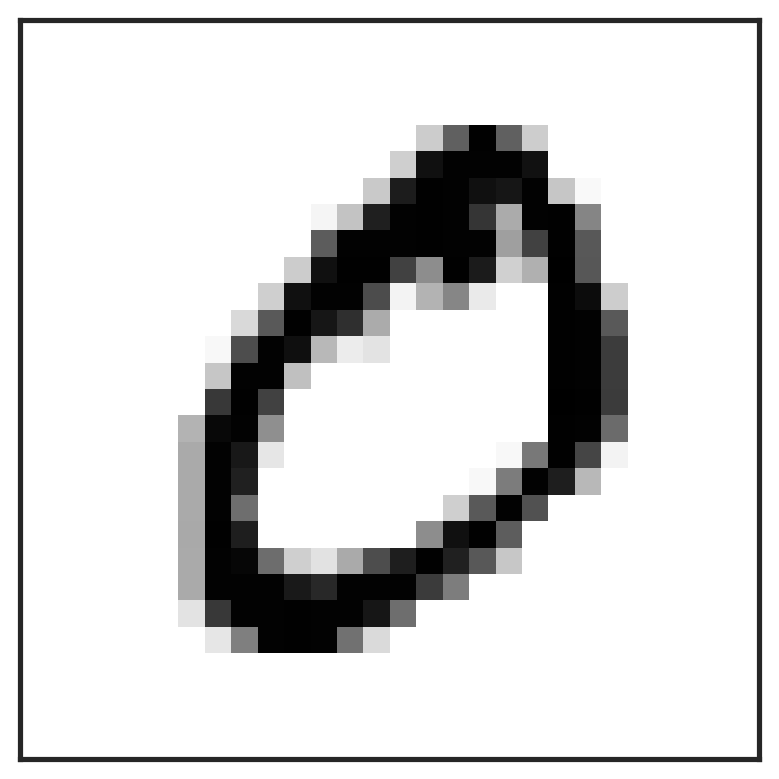

In [4]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[1, :, :])

# Multinomial logistic regression

The target labels are encoded as a nubmer `n` between 0 and 9:

In [5]:
print(np.unique(Y_train))

[0 1 2 3 4 5 6 7 8 9]


But these are categories, not really numbers. 
We know how to do logistic regression for two categories using a single boolean, and the extension of this idea to $L>2$ categories is called [*multinomial logistic regression*](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) or *softmax regression* (not *multiple*, which means multiple features).
In this framework, we try to predict the log odds ratio $z_k$ that a specific sample or example (a set of feature values $x$) is from category $k$ out of $L$ categories.
So instead of each $x_j$ (out of $m$ features) affecting just a single $z$ via a coefficient $a_j$, we have each $x_j$ affecting each log-odds $z_k$ via a coefficient $a_{k,j}$

$$
z_{k} = \sum_{j=1}^m{a_{k,j} x_j}
$$

If we take the n-by-m matrix $\mathbf{W}$ to have the entries $a_{k,j}$ at row $k$ and column $j$, and $\mathbf{x}$ to be the feautres vector in which $x_{j}$ is the $j$-th feature of the sample, then we can write the same equation using matrix multiplication

$$
\mathbf{z} = \mathbf{W}\mathbf{x}
$$

The probability that the sample is from category $k$ is the result of the [*softmax function*](https://en.wikipedia.org/wiki/Softmax_function), an extension of the logistic function for multiple values

$$
\widehat y_k = P(y=k \mid \mathbf{x}) = \frac{e^{z_k}}{\sum_{i=0}^{L-1}{e^{z_i}}}
$$

Note that now $y$, the true label, has to be converted to a vector $\mathbf{y}$ of length $L$ with 1 in one of the positions and 0 everywhere else, so that it would be comparable to $\mathbf{\widehat y}$ which is a probability vector that we get from the log-odds vector $\mathbf{z}$.
The conversion of $y$ from a number between $0$ and $L-1$ to a vector of length $L$ is called [*one-hot encoding*](https://en.wikipedia.org/wiki/One-hot).
Let's write a function for this conversion:

In [6]:
def onehot(labels):
    """0 -> [1,0,0,...,0]
       1 -> [0,1,0,...,0]
       9 -> [0,0,...,0,1]
    """
    nsamples = len(labels)
    Y = np.zeros((nsamples, len(np.unique(labels))))
    Y = Y.at[np.arange(nsamples), labels].set(1) # jax equivalent to Y[np.arange(nsamples), labels] = 1
    return Y

And apply it to our target data:

In [7]:
Y_train = onehot(Y_train)
Y_test = onehot(Y_test)
ncats = Y_test.shape[1]

Note that we could also use `jax.nn.one_hot` or `keras.utils.to_categorical` to do the same job.

Let's see some images with their labels; each time we run this cell we'll get a random image.

0
[1 0 0 0 0 0 0 0 0 0]


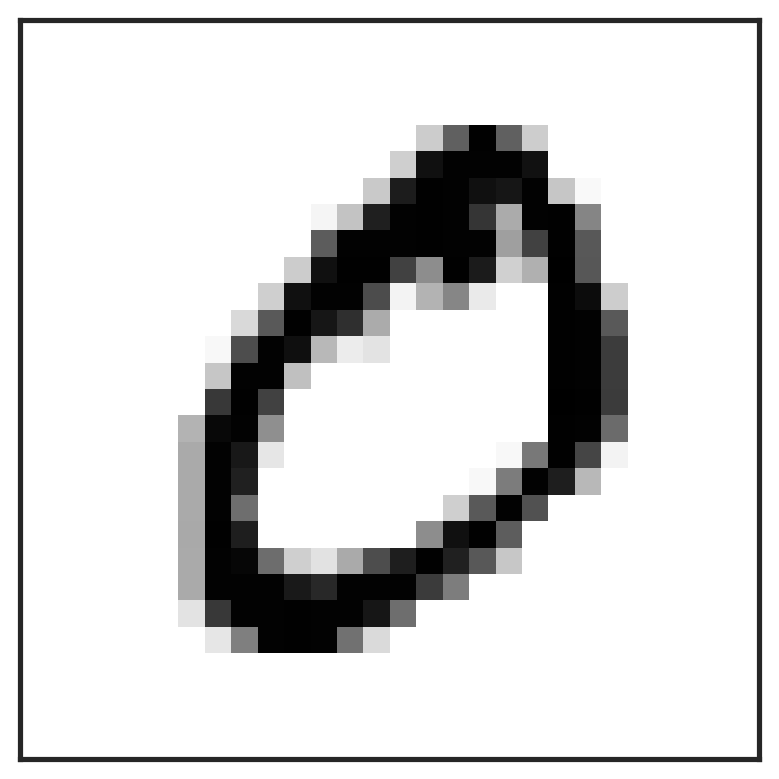

In [8]:
idx = 1
display_image(X_train[idx, :, :])
print(Y_train[idx].argmax())
print(Y_train[idx].astype(int))

Another issue is that our linear model can't handle 2D arrays (images) so we have to reshape our `X`s so that they will be of shape `(nsamples, nfeatures)`.

In [9]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

So Let's start with the multinomial logistic or softmax model.
The model is specified by

$$
\mathbf{\widehat y} = softmax(\mathbf{W} \mathbf{x})
$$

where $\widehat y_k$ is the predicted probability of the sample being in class $k$ just as with the logistic model (here $(\mathbf{W} \mathbf{x})_k$ is the log-odds for the sample being vs. not being in class $k$).

Let's write a function that creates $\mathbf{W}$ and initilize it to some random values; the specific random distribution we chose is called [*Glorot uniform*](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and is commonly used in deep learning algorithms.

JAX note: Because [JAX pseudo-random number generation](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html) works differently than NumPy -- the generator is stateless, so we need to provide a "random key" (i.e. seed) at every function call. Random functions consume the key, but do not modify it. Feeding the same key to a random function will always result in the same sample being generated. To generate different and independent samples, we must `split()` the key.

In [10]:
def random_matrix(key, ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return jax.random.uniform(key, minval=-boundary, maxval=boundary, shape=(ninputs, noutputs))

We now write the softmax function.
We change it a bit to avoid numerical issues of overflow by substracting the largest $z_k$ from the other $z_j$s, so that we deal with exponents of negative numbers, which are easier to compute with high precision.

$$
z_M = max_k{z_k},
$$
$$
\frac{e^{z_k}}{\sum_{j=1}^{L}{e^{z_j}}} = \frac{e^{z_k - z_M}}{\sum_{j=1}^{L}{e^{z_j - z_M}}}
$$

We also write the function so that it would work on a matrix in which each rows are samples and columns are categories, so `max` and `sum` are taken over rows (`axis=1`).
`keepdims` prevents the aggregation matrices from reducing the number of dimensions which would screw our calculations later on.

In [11]:
def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

# Prediction

We implement a prediction function, that accepts an array `W` and array `X` and outputs an array `Yhat`.
For each row in `X` have a row in `Yhat` with 10 elements corresponding to the probabilities for that row being in each of the $L=10$ categories (digits)

The `@` operator performs matrix multiplication in Python.

In [15]:
def predict(W, X):
    X = np.atleast_2d(X) # consistent with scikit-learn and keras that want X to be 2D    
    Z = X @ W # (n, 784) x (784, 10) -> (n, 10)
    Yhat = softmax(Z) # -> (n, 10)
    return Yhat

In [16]:
key = jax.random.PRNGKey(1)
subkey, key = jax.random.split(key)
W = random_matrix(subkey, nfeatures, ncats)
yhat = predict(W, X_test[0,:])

print('truth:', Y_test[0,:].argmax())
print('prediction:', yhat.argmax())

truth: 7
prediction: 8


# Cross entropy and accuracy

The softmax model uses the same cross entropy function as the logistic model, but with an additional step of averaging not just over samples but also over categories.

We can also use `jax.nn.cross_entropy`.

In [17]:
def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.mean()

Accuracy is calculated by comparing the `argmax` of $\mathbf{y}$, the position at which there is a `1` which gives the correct label (so basically reversing the one-hot encoding...), and the argmax of $\mathbf{\widehat y}$, which is the position or category with the highest probability. The `argmax` is taken over rows - samples - using `axis=1`.

Here, the `==` opertor returns an array of booleans, which are sub-types of integers, and `mean` calculates their average, which is the fraction of samples with the correct prediction.

In [18]:
def accuracy(Yhat, Y):
    return (Yhat.argmax(axis=1) == Y.argmax(axis=1)).mean()

In [64]:
W = random_matrix(jax.random.PRNGKey(15), nfeatures, ncats)
t = 0
print("Accuracy:", accuracy(predict(W, X_test), Y_test))

Accuracy: 0.0993


This seems about right, as a random model ($\mathbf{W}$) should be expected to be correct at about 10% of the test samples - We didn't fit the model yet!

# Gradient descent

Let's fit the model now.
First we write the function that calculates the gradient.
This is similar to gradient calculation we wrote for logistic regression, but there is some difference.

With [logistic regression](../solutions/logistic-model.ipynb) we effectively had the following code, with $\mathbf{X}$ a matrix with rows for samples and columns for features, $\mathbf{Y}$ a vector with one entry per sample, and $\mathbf{W}$ a vector with one entry per feature.

```python
def gradient_descent(X, Y, a, η=0.01):
    nsamples = Y.shape[0]
    
    Z = X @ a
    Yhat = 1 / (1 + np.exp(-Z))
    δ = Yhat - Y
    dJda = X.T @ δ / nsamples
    assert dJda.shape == a.shape
    return a - η * dJda
```

This worked well because 
`X` was 2D `(nsamples, nfeatures)`, `W` was 1D array `(nfeatures)` and `Y` was 1D `(nsamples)`.
Multiplying `X * W` caused *broadcasting*, such that `W` was automatically reshaped to `(1, nfeatures)` and then to `(nsamples, nfeatures)`. Then the multiplycation worked elementwise $\mathbf{X}_{k,j} \cdot \mathbf{W}_{k,j}$.

This wouldn't work now because `X` is 2D with shape `(nsamples, nfeatures)`, `W` is 2D with shape `(nfeatures, ncats)` and `Y` and `Yhat` are 2D with shape `(nsamples, ncats)`.
So elementwise multiplycation of `X * W` doesn't have a meaning and cannot be broadcasted.

However, if we use matrix multiplication then `X @ W` is 2D `(nsamples, ncats)` as we require from `Yhat` (`expit` doesn't change the shape as it works elementwise).

The matrix multiplication of `X` and `δ` works fine, as broadcasting works just as we want it to, as long as we take the transpose of `X`.

After multiplication we average over the first axis (`nsamples`) so that we get a 2D `(nfeatures, ncats)` array, the same shape as `W`.

This clever design is worth it, because in Python *no loops = efficeint computation*.

In [83]:
def gradient_descent(W, X, Y, η=0.0001):
    X = np.atleast_2d(X) # consistent with scikit-learn and keras that want X to be 2D    
    nsamples = X.shape[0]
    assert Y.shape[0] == nsamples, "First dimension of X and Y must match"
    # forward
    Z = X @ W # (n, 784) x (784, 10) -> (n, 10)
    Yhat = softmax(Z) # -> (n, 10)
    # backward    
    δ = Yhat - Y # -> (n, 10)
    dJdW = X.T @ δ / nsamples # (784, n) @ (n, 10) -> (784, 10)
    assert dJdW.shape == W.shape, (dJdW.shape, W.shape)
    # descent
    return W - η * dJdW

In [37]:
%timeit gradient_descent(W, X_train[:50], Y_train[:50])

703 µs ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# JITing the training step

We can pass the gradient descent function through `jax.jit`, which [just-in-time compiles the function](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) so it can be executed efficiently in XLA.

In [113]:
gradient_descent = jax.jit(gradient_descent)

In [67]:
gradient_descent(W, X_train[:50], Y_train[:50]) # compile before timeit
%timeit gradient_descent(W, X_train[:50], Y_train[:50])

348 µs ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


On my PC this improves running time 2-fold, but on different PCs this can have a different effect depending on the hardware (CPUs, GPUs, etc.)

# Training with stochastic gradient descent

At every training step, we compute the gradients and update the coeffieint matrix $\mathbf{W}$. 
We doesn't use all the images at each update but rather just a batch of 50 images.
This is called [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) because we try to estimate the gradient from a sample of the data rather the entire data.
It works well because (i) it's more efficeint in terms of memory to use 50 images at a time; and (ii) it helps to prevent over-fitting and escaping from local minima (of the cross entropy function) because at each stage we use a different set of images.

We have 60,000 images, and work with batches of 50, so it takes 1,200 batches to go over the entire dataset.
This is called an _epoch_.
Let's train for 10 epochs.

In [103]:
batch_size = 50 
epochs = 0
batches = 0
nsamples = X_train.shape[0]

W = random_matrix(jax.random.PRNGKey(15), nfeatures, ncats)
t = 0
print("Accuracy:", accuracy(predict(W, X_test), Y_test))

Accuracy: 0.0993


In [104]:
%%time
while epochs < 5:
    # update loop variables
    batches += 1
    epochs = batches * batch_size // nsamples
    
    # get next batch
    start = (batches * batch_size) % nsamples
    stop = start + batch_size
    X_, Y_ = X_train[start:stop, :], Y_train[start:stop, :]
    
    # gradient descent
    W = gradient_descent(W, X_, Y_)
    
    # print once every epoch
    if batches * batch_size % nsamples == 0:
        acc = accuracy(predict(W, X_test), Y_test)
        print("Epoch {}, test accuracy: {}".format(epochs, acc))    

Epoch 1, test accuracy: 0.8596000075340271
Epoch 2, test accuracy: 0.868399977684021
Epoch 3, test accuracy: 0.8693000078201294
Epoch 4, test accuracy: 0.8772000074386597
Epoch 5, test accuracy: 0.8704999685287476
CPU times: user 3.73 s, sys: 376 ms, total: 4.1 s
Wall time: 3.99 s


Nice, with 10 epochs we get an accuracy of 91%-92%.
The result is sensitive to the choice of `η`.

In [105]:
def display_prediction(idx):
    print(predict(W, X_test[idx, :]).argmax())
    return display_image(X_test[idx].reshape(28, 28))

9


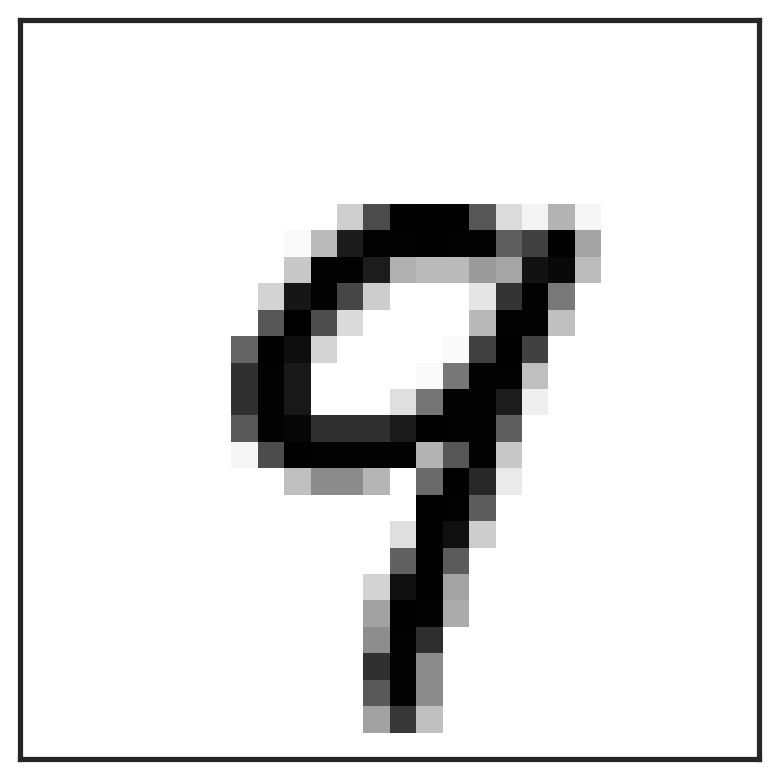

In [106]:
display_prediction(12)

Which labels are confused with which? We can use Scikit-learn to createa [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [107]:
y_true = Y_test.argmax(axis=1)
y_pred = predict(W, X_test).argmax(axis=1)

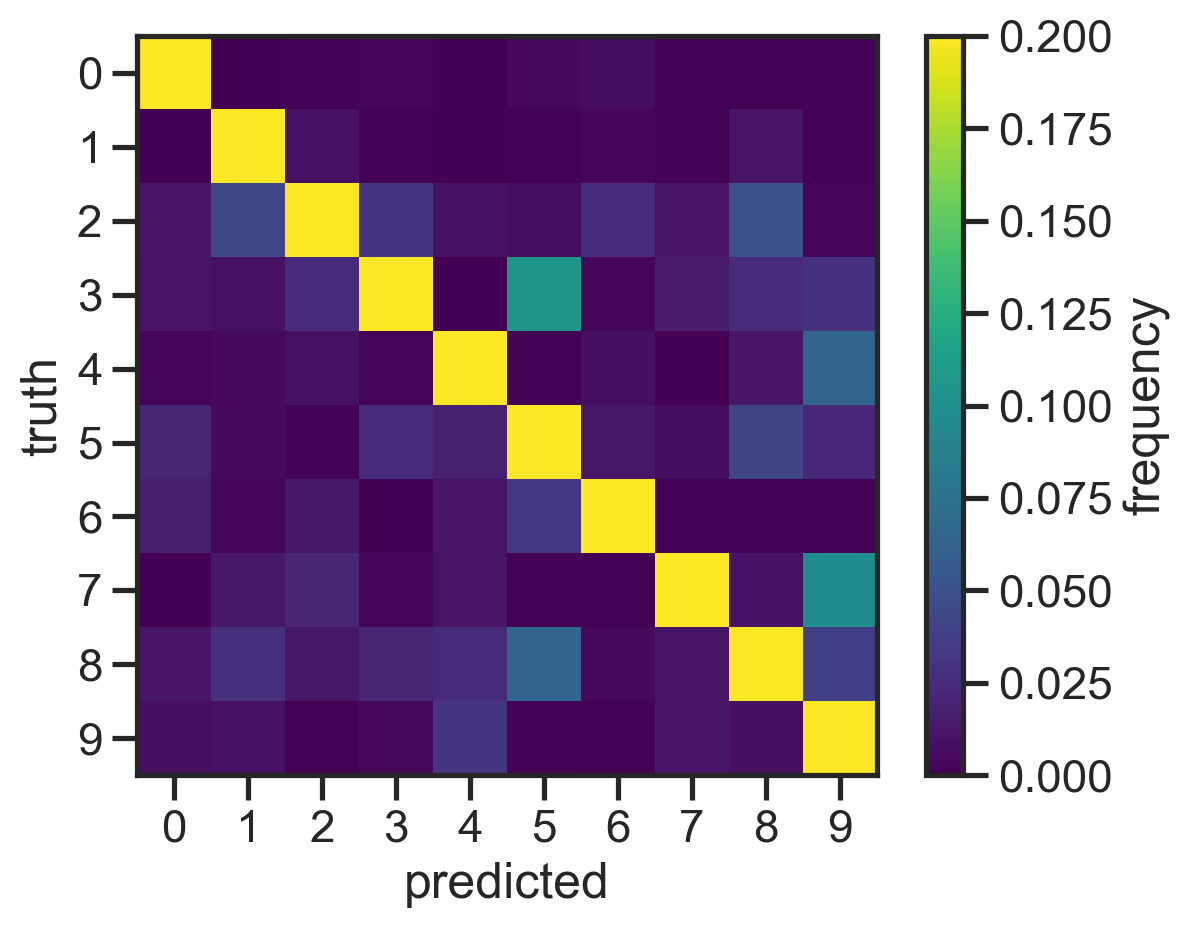

In [108]:
conf = confusion_matrix(y_true, y_pred, normalize='pred')
plt.imshow(conf, origin='upper', cmap='viridis', vmin=0, vmax=0.2)
plt.xlabel('predicted')
plt.ylabel('truth');
plt.xticks(range(10))
plt.yticks(range(10))
plt.colorbar(label='frequency');

# Saving the fitted model

NumPy has special pickling functions for arrays, and in this case all the model information is in the `W` array.

I like to save it compressed to `.npz` but there are [other options].

In [116]:
np.save('../data/softmax_reg_model_jax.npy', W)
del W

Loading is easy:

In [117]:
W = np.load('../data/softmax_reg_model_jax.npy')

and we can use it again.

5


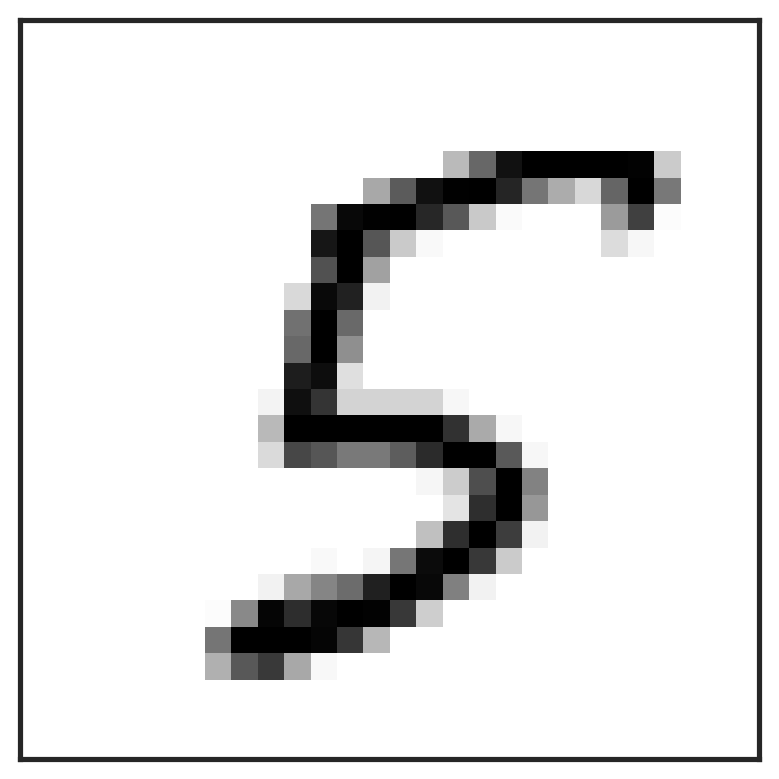

In [118]:
display_prediction(23)

# Problem

The major assumption of the softmax model is the linear relationship between the features $x_j$ and the log-odds $z_k$, which translates to a logistic relationship between the features and the probabilityies $\widehat y_k$.

But what can we do if the relationship is not linear, or worse, not even monotonic?

The neural network solution: instead of just looking for the values of $W$ that would make the model fit the data, we can use a stack a bunch of linear models:
$$
\mathbf{X_2} = f_1(\mathbf{X_1} \mathbf{W_1}) $$$$
\mathbf{X_3} = f_2(\mathbf{X_2} \mathbf{W_2}) $$$$
\ldots $$$$
\mathbf{\widehat Y} = softmax(\mathbf{X_n} \mathbf{W_n})
$$
and fit this model to the data by looking for $\mathbf{W_1}, \ldots, \mathbf{W_n}$ that give us a good prediction.

Note that all of the mathematical details are the same: we can still use gradient descent to fit the model, and we can still calculate the gradients using the chain rule.
The additional power of the model comes from adding multiple *layers* of linear models; the *simplicity* fo the model is maintained because we are adding linear models, which we already know how to handle, rather than adding arbitray models.
Interestingly, if we add just a bit of non-linerity (we'll see what that means) we can approximate a very wide range of relationships between $x$ and $P(y=k)$, without engineering features on our own.

The downside is that we are fitting many more *model parameters* ($W_k$), which involves longer computation and requires more sophisticated strategies for gradient descent.
These issues are the subject of [intense research](https://arxiv.org/list/cs.NE/recent) both in Academia and in Industry.

So this was the motivation for our next session on [feed forward networks](FFN.ipynb).

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://python.yoavram.com/Deep4Devs) workshops.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)